In [1]:
%matplotlib inline

In [10]:
import pprint

Distance Metrics
================
* distances between two bags of words or distributions.


In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

* document similarity: see [Tutorial](https://radimrehurek.com/gensim/tut3.html) and [API](https://radimrehurek.com/gensim/similarities/docsim.html). Next:

1. Define corpus of documents belonging to one of two topics
2. Train an LDA model to distinguish between the two topics
3. Use the model to obtain distributions for some sample words
4. Compare the distributions to each other using a variety of distance metrics:
  * Hellinger
  * Kullback-Leibler
  * Jaccard
5. Some details

In [3]:
from gensim.corpora import Dictionary

# you can use any corpus, this is just illustratory
texts = [
    ['bank','river','shore','water'],
    ['river','water','flow','fast','tree'],
    ['bank','water','fall','flow'],
    ['bank','bank','water','rain','river'],
    ['river','water','mud','tree'],
    ['money','transaction','bank','finance'],
    ['bank','borrow','money'], 
    ['bank','finance'],
    ['finance','money','sell','bank'],
    ['borrow','sell'],
    ['bank','loan','sell'],
]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

import numpy
numpy.random.seed(1) # setting random seed to get the same results each time.

from gensim.models import ldamodel
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)
model.show_topics()

[(0,
  '0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.053*"tree" + 0.045*"flow" + 0.044*"rain"'),
 (1,
  '0.142*"bank" + 0.116*"water" + 0.090*"river" + 0.084*"money" + 0.081*"finance" + 0.064*"flow" + 0.055*"transaction" + 0.055*"tree" + 0.053*"fall" + 0.050*"mud"')]

* Define the 1st & 2nd topics: **water**, **finance**. 
* Take some sample docs, prep them for testing.

In [4]:
doc_water   = ['river',   'water', 'shore']
doc_finance = ['finance', 'money', 'sell']
doc_bank    = ['finance', 'bank',  'tree', 'water']

# convert to BoW format
bow_water   = model.id2word.doc2bow(doc_water)   
bow_finance = model.id2word.doc2bow(doc_finance)   
bow_bank    = model.id2word.doc2bow(doc_bank)   

# get the LDA topic distributions for each
lda_bow_water   = model[bow_water]
lda_bow_finance = model[bow_finance]
lda_bow_bank    = model[bow_bank]

Hellinger Distance
---------

* These metrics return a value [0:1]. close to 0 = smaller distance = larger similarity.
* **Hellinger distance metric** does this for two probability distributions.

In [5]:
from gensim.matutils import hellinger
print(hellinger(lda_bow_water, lda_bow_finance))
print(hellinger(lda_bow_finance, lda_bow_bank))

0.24622736579004378
0.0073329423962157055


* example 1: 'water' & 'finance' are hardly similar.
* example 2: 'bank' & finance' are more semantically similar.

[Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
----------------
Let's run similar examples down with Kullback Leibler.

In [6]:
from gensim.matutils import kullback_leibler

print(kullback_leibler(lda_bow_water, lda_bow_bank))
print(kullback_leibler(lda_bow_finance, lda_bow_bank))

0.22783141
0.00021458045


* KL is not a distance metric in the mathematical sense - hence not symmetrical.
* This means _kullback_leibler(lda_bow_finance, lda_bow_bank)_ is not equal to _kullback_leibler(lda_bow_bank, lda_bow_finance)_.

In [7]:
print(kullback_leibler(lda_bow_bank, lda_bow_finance))

0.00021560304


* Previous: we saw lower distance values between bank:finance than for bank:water, but not by a huge margin. What does this mean?
* The *bank* document is a **combination** of water and finance related terms - but as bank in this context is likely to belong to the finance topic. The distance values are less between the finance and bank BoWs.

In [8]:
# just to confirm our suspicion that the bank bow is more to do with finance (does it?):
model.get_document_topics(bow_bank)

[(0, 0.6412682), (1, 0.35873184)]

* Distance/similarity metrics: further reading on [Kullback Leibler](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) or [Hellinger](https://en.wikipedia.org/wiki/Hellinger_distance)

### [Jaccard distance](https://en.wikipedia.org/wiki/Jaccard_index)



In [9]:
from gensim.matutils import jaccard

print(jaccard(bow_water, bow_bank))
print(jaccard(doc_water, doc_bank))
print(jaccard(['word'], ['word']))

0.8571428571428572
0.8333333333333334
0.0


Distance Metrics for Topic Distributions
----------------------------------------
* Let's say we want to find the similarity of the following topics: water and finance.


In [12]:
topic_water, topic_finance = model.show_topics()

# some pre processing to get the topics in a format acceptable to our distance metrics

def parse_topic_string(topic):
    # takes the string returned by model.show_topics()
    # split on strings to get topics and the probabilities
    topic = topic.split('+')
    
    # list to store topic bows
    topic_bow = []
    
    for word in topic:
    
        # split probability and word
        prob, word = word.split('*')
        
        # get rid of spaces and double quote marks
        word = word.replace(" ","").replace('"', '')
        
        # convert to word_type
        word = model.id2word.doc2bow([word])[0][0]
        topic_bow.append((word, float(prob)))
        
    return topic_bow

finance_distribution = parse_topic_string(topic_finance[1])
water_distribution   = parse_topic_string(topic_water[1])

# the finance topic in bag of words format looks like this:
pprint.pprint(finance_distribution)

[(0, 0.142),
 (3, 0.116),
 (1, 0.09),
 (11, 0.084),
 (10, 0.081),
 (5, 0.064),
 (12, 0.055),
 (6, 0.055),
 (7, 0.053),
 (9, 0.05)]


In [13]:
print(hellinger(water_distribution, finance_distribution))

0.42898539619904935


* The topics aren't TOO distant with respect to their word distributions.
* This makes sense - overlapping words like ``bank``, & small size dictionary.

Kullback-Leibler Gotchas
------------------------
* Remember that KL is a similarity test, not a distance metric.

In [14]:
# 16 = #features the probability distribution draws from

print(kullback_leibler(water_distribution, finance_distribution, 16))

inf


* That wasn't very helpful, right? It means we have to be careful about our inputs. 
* The old example didn't work out because they were some missing values for some words (because ``show_topics()`` only returned the top 10 topics). 
* This can be remedied, though.

In [15]:
# return ALL the words in the dictionary for the topic-word distribution.
topic_water, topic_finance = model.show_topics(
    num_words=len(
        model.id2word))

# do our bag of words transformation again
finance_distribution = parse_topic_string(topic_finance[1])
water_distribution   = parse_topic_string(topic_water[1])

# and voila!
pprint.pprint(kullback_leibler(water_distribution, finance_distribution))

0.087688535


* This distance indicates high similarity, perhaps due to the small corpus size - all topics are likely to contain a decent overlap of word probabilities. You will likely get a better value for a bigger corpus.
* Remember: if you intend to use KL as a similarity metric, avoid zeros by returning the ENTIRE distribution. 

What are Distance Metrics?
--------------------------
There are 4 conditons for for a distance measure to be a metric:

1. d(x,y) >= 0 (non-negative)
2. d(x,y) = 0 <=> x = y ( if x & y are the same, distance is zero)
3. d(x,y) = d(y,x) (symmetric)
4. d(x,z) <= d(x,y) + d(y,z) (obeys triangle equality)

In [16]:
# normal Hellinger
a = hellinger(water_distribution, finance_distribution)
b = hellinger(finance_distribution, water_distribution)
print(a)
print(b)
print(a == b)

# if we pass the same values, it is zero.
print(hellinger(water_distribution, water_distribution))

# for triangle inequality let's use LDA document distributions
print(hellinger(lda_bow_finance, lda_bow_bank))

# Triangle inequality works too! (?-review triangle equality)
print(hellinger(lda_bow_finance, lda_bow_water) + hellinger(lda_bow_water, lda_bow_bank))

0.14950162744749795
0.14950162744749795
True
0.0
0.0073329423962157055
0.4852304816311588


* So Hellinger is indeed a metric. Let's check out KL. 

In [17]:
a = kullback_leibler(finance_distribution, water_distribution)
b = kullback_leibler(water_distribution, finance_distribution)
print(a,b,a==b)

0.09273797 0.087688535 False


* When we swap the values they aren't equal! (FAILS SYMMETRY). 
* However, just because it's not a metric, doesn't mean that KL isn't useful. 
* KL Divergence is widely used & a notable distance measure in Info Theory.
* [Hellinger-KL differences](http://stats.stackexchange.com/questions/130432/differences-between-bhattacharyya-distance-and-kl-divergence).

Visualizing Distance Metrics with [Networkx](https://networkx.github.io/documentation/stable/)
------------------------------------------

* Each node is a document. Node color = topic according to LDA model. 
* Edges connect documents. Edge weight = inversely proportional to the Jaccard
similarity between two documents. 
* Annotate the edges with **strong** edges for similar documents and **weak (dashed)** edges for dissimilar documents.
* In summary: similar documents will be closer together, different documents will be further apart.

{0: Text(0.8139056554148585, -0.1385144383214792, '0'),
 1: Text(-0.2609162263425896, 0.8290751405979758, '1'),
 2: Text(0.12108432357837688, 0.2521192345954642, '2'),
 3: Text(0.7410538444428034, 0.3897745756787509, '3'),
 4: Text(0.3571060747096814, 0.8878304053766498, '4'),
 5: Text(-0.19185848377519837, -0.4814192613354953, '5'),
 6: Text(-0.7484781508847783, -0.5667501948434654, '6'),
 7: Text(-0.7291843541015196, 0.3730910679100171, '7'),
 8: Text(0.38214490760132847, -0.5064739523722547, '8'),
 9: Text(0.07139744748226842, -1.0, '9'),
 10: Text(-0.5562550381252319, -0.03873257728616475, '10')}

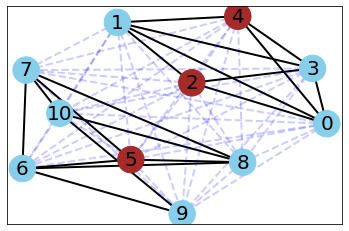

In [18]:
import itertools
import networkx as nx

def get_most_likely_topic(doc):
    bow                   = model.id2word.doc2bow(doc)
    topics, probabilities = zip(*model.get_document_topics(bow))
    max_p                 = max(probabilities)
    topic                 = topics[probabilities.index(max_p)]
    return topic

def get_node_color(i):
    return 'skyblue' if get_most_likely_topic(texts[i]) == 0 else 'brown'

G = nx.Graph()

for i, _ in enumerate(texts):
    G.add_node(i)
    
for (i1, i2) in itertools.combinations(range(len(texts)), 2):
    bow1, bow2 = texts[i1], texts[i2]
    distance   = jaccard(bow1, bow2)
    G.add_edge(
        i1, i2, weight=1/distance)
    
#
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html
#

pos = nx.spring_layout(G)

threshold = 1.25
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > threshold]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= threshold]

node_colors = [get_node_color(i) for (i, _) in enumerate(texts)]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2)
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2, alpha=0.2, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

### Observations

* 1) graph consists of two connected components (if you ignore the weak edges).
Nodes 0, 1, 2, 3, 4 (which all belong to the water topic) form the first connected component. The other nodes (all belonging to the finance topic), form the second connected component.
* 2) LDA didn't do a very good job of classifying our documents into topics. See below.

In [19]:
print('id\ttopic\tdoc')
for i, t in enumerate(texts):
    print('%d\t%d\t%s' % (i, get_most_likely_topic(t), ' '.join(t)))

id	topic	doc
0	0	bank river shore water
1	0	river water flow fast tree
2	1	bank water fall flow
3	0	bank bank water rain river
4	1	river water mud tree
5	1	money transaction bank finance
6	0	bank borrow money
7	0	bank finance
8	0	finance money sell bank
9	0	borrow sell
10	0	bank loan sell


* This is mostly because the corpus used to train the LDA model is so small.

### Resources
----------
* Larger suite of metrics to add to _matutils.py_: [Similarity Measures for Text Document Clustering](http://www.academia.edu/download/32952068/pg049_Similarity_Measures_for_Text_Document_Clustering.pdf)